# Model Training

We use VAE to train our model. We then visualize it on the trained latent space.

In [12]:
#VAE code from PyTorch Tutorial

from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

In [13]:
epochs = 10

parser = argparse.ArgumentParser(description='VAE MNIST Example')


device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 10) # dimension of latent sapce = 10
        self.fc22 = nn.Linear(400, 10)
        self.fc3 = nn.Linear(10, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            '''
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

            '''
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    #print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 10).to(device)
            sample = model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),'cur_result/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 223.7180
====> Epoch: 2 Average loss: 150.7219
====> Epoch: 3 Average loss: 133.5656
====> Epoch: 4 Average loss: 127.2752
====> Epoch: 5 Average loss: 123.7707
====> Epoch: 6 Average loss: 121.5046
====> Epoch: 7 Average loss: 119.8999
====> Epoch: 8 Average loss: 118.5908
====> Epoch: 9 Average loss: 117.5811
====> Epoch: 10 Average loss: 116.7298


In [14]:
torch.save(model, './model')

/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
model = torch.load('./model')

This section is performing random sampling on embedded space.

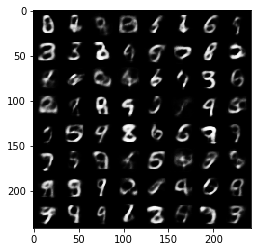

__main__


In [31]:
import matplotlib.pyplot as plt
import numpy as np


temp = torch.randn(64, 10).to(device)
temp = model.decode(temp).cpu()

with torch.no_grad():
    sample = torch.randn(64, 10).to(device)
    sample = model.decode(sample).cpu()
    plt.figure()
    show(make_grid(sample.view(64, 1, 28, 28)))
    plt.show()

print(show.__module__)
#imgplot = plt.imshow(temp2[:,1])
#print(type(temp2))

# Hilbert library
Modified from https://github.com/galtay/hilbertcurve

Add function get_next_time


In [17]:

def _binary_repr(num, width):
    """Return a binary string representation of `num` zero padded to `width`
    bits."""
    return format(num, 'b').zfill(width)



class HilbertCurve:

    def __init__(self, p, n):
        """Initialize a hilbert curve with,

        Args:
            p (int): iterations to use in the hilbert curve
            n (int): number of dimensions
        """
        if p <= 0:
            raise ValueError('p must be > 0')
        if n <= 0:
            raise ValueError('n must be > 0')
        self.p = p
        self.n = n

        # maximum distance along curve
        self.max_h = 2**(self.p * self.n) - 1

        # maximum coordinate value in any dimension
        self.max_x = 2**self.p - 1

    def _hilbert_integer_to_transpose(self, h):
        """Store a hilbert integer (`h`) as its transpose (`x`).

        Args:
            h (int): integer distance along hilbert curve

        Returns:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)
        """
        h_bit_str = _binary_repr(h, self.p*self.n)
        x = [int(h_bit_str[i::self.n], 2) for i in range(self.n)]
        return x

    def _transpose_to_hilbert_integer(self, x):
        """Restore a hilbert integer (`h`) from its transpose (`x`).

        Args:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)

        Returns:
            h (int): integer distance along hilbert curve
        """
        x_bit_str = [_binary_repr(x[i], self.p) for i in range(self.n)]
        h = int(''.join([y[i] for i in range(self.p) for y in x_bit_str]), 2)
        return h

    def coordinates_from_distance(self, h):
        """Return the coordinates for a given hilbert distance.

        Args:
            h (int): integer distance along hilbert curve

        Returns:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)
        """
        if h > self.max_h:
            raise ValueError('h={} is greater than 2**(p*N)-1={}'.format(h, self.max_h))
        if h < 0:
            raise ValueError('h={} but must be > 0'.format(h))

            
        #Example: 5 bits for each of n=3 coordinates.
        #15-bit Hilbert integer = A B C D E F G H I J K L M N O is stored as its Transpose                        ^
        #X[0] = A D G J M                    X[2] |  7
        #X[1] = B E H K N        <------->        | /X[1]
        #X[2] = C F I L O                   axes  |/
        #        high low                         0------> X[0]
        # each element in x is a p-digit value
        
        x = self._hilbert_integer_to_transpose(h)
        Z = 2 << (self.p-1)

        # Gray decode by H ^ (H/2)
        # for iteration, can be parallelized
        t = x[self.n-1] >> 1
        for i in range(self.n-1, 0, -1):
            x[i] ^= x[i-1]
        x[0] ^= t

        # Undo excess work
        Q = 2
        while Q != Z:
            P = Q - 1
            for i in range(self.n-1, -1, -1):
                if x[i] & Q:
                    # invert
                    x[0] ^= P
                else:
                    # exchange
                    t = (x[0] ^ x[i]) & P
                    x[0] ^= t
                    x[i] ^= t
            Q <<= 1

        # done
        return x

    def distance_from_coordinates(self, x_in):
        """Return the hilbert distance for a given set of coordinates.

        Args:
            x_in (list): transpose of h
                         (n components with values between 0 and 2**p-1)

        Returns:
            h (int): integer distance along hilbert curve
        """
        x = list(x_in)
        if len(x) != self.n:
            raise ValueError('x={} must have N={} dimensions'.format(x, self.n))

        if any(elx > self.max_x for elx in x):
            raise ValueError(
                'invalid coordinate input x={}.  one or more dimensions have a '
                'value greater than 2**p-1={}'.format(x, self.max_x))

        if any(elx < 0 for elx in x):
            raise ValueError(
                'invalid coordinate input x={}.  one or more dimensions have a '
                'value less than 0'.format(x))

        M = 1 << (self.p - 1)

        # Inverse undo excess work
        Q = M
        while Q > 1:
            P = Q - 1
            for i in range(self.n):
                if x[i] & Q:
                    x[0] ^= P
                else:
                    t = (x[0] ^ x[i]) & P
                    x[0] ^= t
                    x[i] ^= t
            Q >>= 1

        # Gray encode
        for i in range(1, self.n):
            x[i] ^= x[i-1]
        t = 0
        Q = M
        while Q > 1:
            if x[self.n-1] & Q:
                t ^= Q - 1
            Q >>= 1
        for i in range(self.n):
            x[i] ^= t

        h = self._transpose_to_hilbert_integer(x)
        return h
    
    def get_next_time(self, cur_t, v):
        next_t = (cur_t * (2**(self.n*self.p)-1) + v) / (2**(self.n*self.p)-1)
        return next_t

# Visualisation of Latent Space

We use the hilbert curve to sample the latent space.

In [18]:
from ipywidgets import interact_manual, interact, Button
from IPython.display import display
import ipywidgets as widgets
#from hilbert import HilbertCurve
import numpy as np

global p_widget, t_widget

#function required to do plotting
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

#N: dimension of embedded space
N = 10

#v: velocity of travelling (the step size it moved on curve when clicking "next time stamp")
v = 10

def plotting(p=4, t=0.6):
    hilbert_curve = HilbertCurve(p, N) #initialize hilbert curve
    cur_dist = int(t * (2**(N*p)-1)) #t is in scale [0,1], dist is in scale[0, 2^(Np)-1]
    
    #sample points near cur_dist
    dists = [cur_dist-10, cur_dist-5, cur_dist, cur_dist+5, cur_dist+10] 
    
    
    coords = [hilbert_curve.coordinates_from_distance(dist) for dist in dists]

    norm_coords = np.array([[[((coord_x / (2**(p-1)))-1) for coord_x in coord]]  for coord in coords])
    #convert coords in hyperspace back to scale [-1,1] (the latent space we're exploring)

    b = torch.tensor(norm_coords).type(torch.FloatTensor).to(device)
    sample = model.decode(b).cpu() #decode norm_coords
    show(make_grid(sample.view(5, 1, 28, 28)))
    cur_t.value = str(t_widget.value)
    cur_pos.value = str(coords[2])
    
    plt.figure()
    x_c = np.arange(N)
    y_c = norm_coords[2].flatten()
    plt.xlabel("Coordinate Index")
    plt.ylabel("Location in Embedded Space (normalized to [-1,1])")
    plt.ylim((-1,1))
    plt.bar(x_c, y_c)
    
    
    
    
p_widget = widgets.IntSlider(min = 1, max = 10, val = 4)
t_widget = widgets.FloatSlider(min=0.1, max = 1,  step=1e-3)

button = Button (description = "Next Time Stamp")
display(button)

def on_button_clicked(b):
    cur_curve = HilbertCurve(p_widget.value, N)
    t_widget.value = cur_curve.get_next_time(t_widget.value,v) #update t_value on widget



button.on_click(on_button_clicked)

interactive_plot = interact(plotting, p = p_widget, t=t_widget)
interactive_plot

cur_t = widgets.Text(description = "Current t: ")
display(cur_t)

cur_pos = widgets.Text(description = "Coordinate: ")
display(cur_pos)



Button(description='Next Time Stamp', style=ButtonStyle())

interactive(children=(IntSlider(value=1, description='p', max=10, min=1), FloatSlider(value=0.1, description='…

Text(value='', description='Current t: ')

Text(value='', description='Coordinate: ')